In [1]:
import os
import cv2
import glob
import keras
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization,MaxPooling2D,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, precision_score, recall_score
from keras.layers import Conv2D,Dense,Dropout,GlobalAveragePooling2D
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import logging
# Set TensorFlow log level to only display errors
tf.get_logger().setLevel(logging.ERROR)

In [5]:
path="flowers"
categories=os.listdir(path)
print(categories)
print(len(categories))

['astilbe', 'bellflower', 'black_eyed_susan', 'calendula', 'california_poppy', 'carnation', 'common_daisy', 'coreopsis', 'daffodil', 'dandelion', 'iris', 'magnolia', 'rose', 'sunflower', 'tulip', 'water_lily']
16


In [6]:
def create_image_dataframe(dataset_dir):
    """
    Creates a DataFrame with image paths and labels from a dataset directory.
    """
    data = []
    
    image_extensions = ['*.png', '*.jpg', '*.jpeg',]
    image_paths = []
    for ext in image_extensions:
        image_paths.extend(glob.glob(os.path.join(dataset_dir, '**', ext), recursive=True))
    
    for path in image_paths:
        label = os.path.basename(os.path.dirname(path))
        data.append((label, path))
    
    df = pd.DataFrame(data, columns=['label', 'path'])
    return df

In [8]:
df=create_image_dataframe(path)
df

,label,path
0,astilbe,flowers\astilbe\10091895024_a2ea04cda6_c.jpg
1,astilbe,flowers\astilbe\1033455028_f0c6518ec9_c.jpg
2,astilbe,flowers\astilbe\10373087134_927b53fb9f_c.jpg
3,astilbe,flowers\astilbe\1052212431_4963309d03_c.jpg
4,astilbe,flowers\astilbe\1052219251_d03970e956_c.jpg
...,...,...
15735,water_lily,flowers\water_lily\9307395870_88e2c9d602_c.jpg
15736,water_lily,flowers\water_lily\9381365165_1e4c66a1a9_c.jpg
15737,water_lily,flowers\water_lily\9388505036_f567902ea1_c.jpg
15738,water_lily,flowers\water_lily\9486809877_b11f0b7046_c.jpg


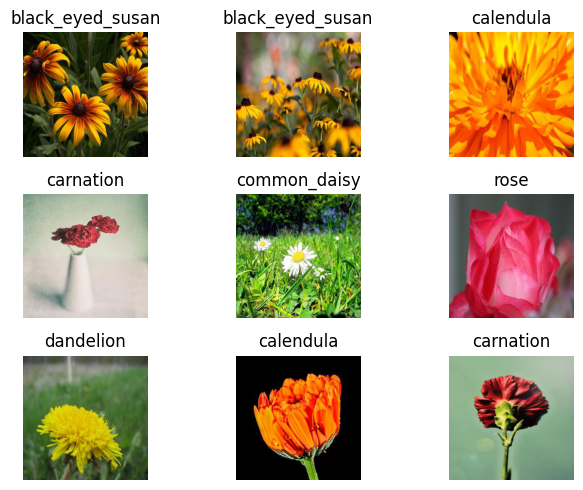

In [11]:
num_images=9
# Randomly sample num_images from the DataFrame
sampled_df = df.sample(n=num_images).reset_index(drop=True)

plt.figure(figsize=(7, 5))

for i in range(num_images):
    plt.subplot(3, 3, i + 1)

    # Read the image
    img_path = sampled_df.iloc[i]['path']
    img = plt.imread(img_path)

    plt.imshow(img)
    plt.title(sampled_df.iloc[i]['label'])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
counts=df['label'].value_counts()
counts

label
iris                1054
dandelion           1052
magnolia            1048
tulip               1048
coreopsis           1047
sunflower           1027
california_poppy    1022
black_eyed_susan    1000
rose                 999
water_lily           982
common_daisy         980
calendula            978
daffodil             970
carnation            923
bellflower           873
astilbe              737
Name: count, dtype: int64

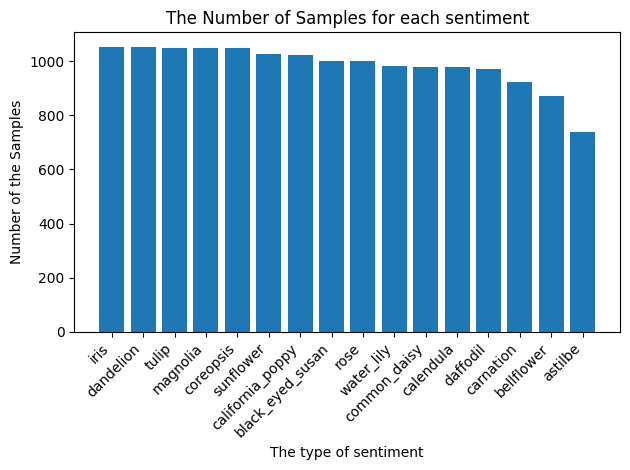

In [13]:
unique_labels=['iris', 'dandelion', 'tulip', 'magnolia', 'coreopsis', 'sunflower', 
 'california_poppy', 'black_eyed_susan', 'rose', 'water_lily', 'common_daisy', 
 'calendula', 'daffodil', 'carnation', 'bellflower', 'astilbe']
plt.bar(unique_labels, counts, width=0.8)  

plt.xlabel('The type of sentiment')
plt.ylabel('Number of the Samples')
plt.title("The Number of Samples for each sentiment")
plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show()

In [14]:
categories

['astilbe',
 'bellflower',
 'black_eyed_susan',
 'calendula',
 'california_poppy',
 'carnation',
 'common_daisy',
 'coreopsis',
 'daffodil',
 'dandelion',
 'iris',
 'magnolia',
 'rose',
 'sunflower',
 'tulip',
 'water_lily']

In [ ]:
selected_labels = categories
import pandas as pd

def select_and_sample_classes(df, selected_labels, num_samples=700):
    
    filtered_df = df[df['label'].isin(selected_labels)]
    
    sampled_df = pd.DataFrame()
    for label in selected_labels:
        label_df = filtered_df[filtered_df['label'] == label].sample(n=num_samples, replace=True)
        sampled_df = pd.concat([sampled_df, label_df], ignore_index=True)
    
    return sampled_df

sampled_df = select_and_sample_classes(df, selected_labels, num_samples=700)
sampled_df['label'].value_counts() 

label
astilbe             700
bellflower          700
black_eyed_susan    700
calendula           700
california_poppy    700
carnation           700
common_daisy        700
coreopsis           700
daffodil            700
dandelion           700
iris                700
magnolia            700
rose                700
sunflower           700
tulip               700
water_lily          700
Name: count, dtype: int64

In [16]:
train_df, temp_df = train_test_split(sampled_df, test_size=0.3, random_state=42)
test_df, valid_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print("Training set shapes:", train_df.shape)
print("Testing set shapes:", test_df.shape)
print("Validation set shapes:", valid_df.shape)

Training set shapes: (7840, 2)
Testing set shapes: (1680, 2)
Validation set shapes: (1680, 2)


In [17]:
train_datagen = ImageDataGenerator(    
    rescale=1.0/255,        
#     shear_range=0.2,
#     rotation_range=.1,
#     zoom_range=0.2,       
#     horizontal_flip=True ,
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path', 
    y_col='label',   
    target_size=(224, 224), 
    batch_size=32,
    class_mode='categorical', 
    color_mode='rgb',
    shuffle=True
)

# Validation data generator
valid_generator = test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='path', 
    y_col='label',
    target_size=(224, 224), 
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False  
)

# Testing data generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path', 
    y_col='label',  
    target_size=(224, 224),  
    color_mode='rgb',
    batch_size=64,  
    class_mode='categorical',
    shuffle=False  
)

Found 7840 validated image filenames belonging to 16 classes.
Found 1680 validated image filenames belonging to 16 classes.
Found 1680 validated image filenames belonging to 16 classes.


In [19]:
classes=list(train_generator.class_indices)
classes

['astilbe',
 'bellflower',
 'black_eyed_susan',
 'calendula',
 'california_poppy',
 'carnation',
 'common_daisy',
 'coreopsis',
 'daffodil',
 'dandelion',
 'iris',
 'magnolia',
 'rose',
 'sunflower',
 'tulip',
 'water_lily']

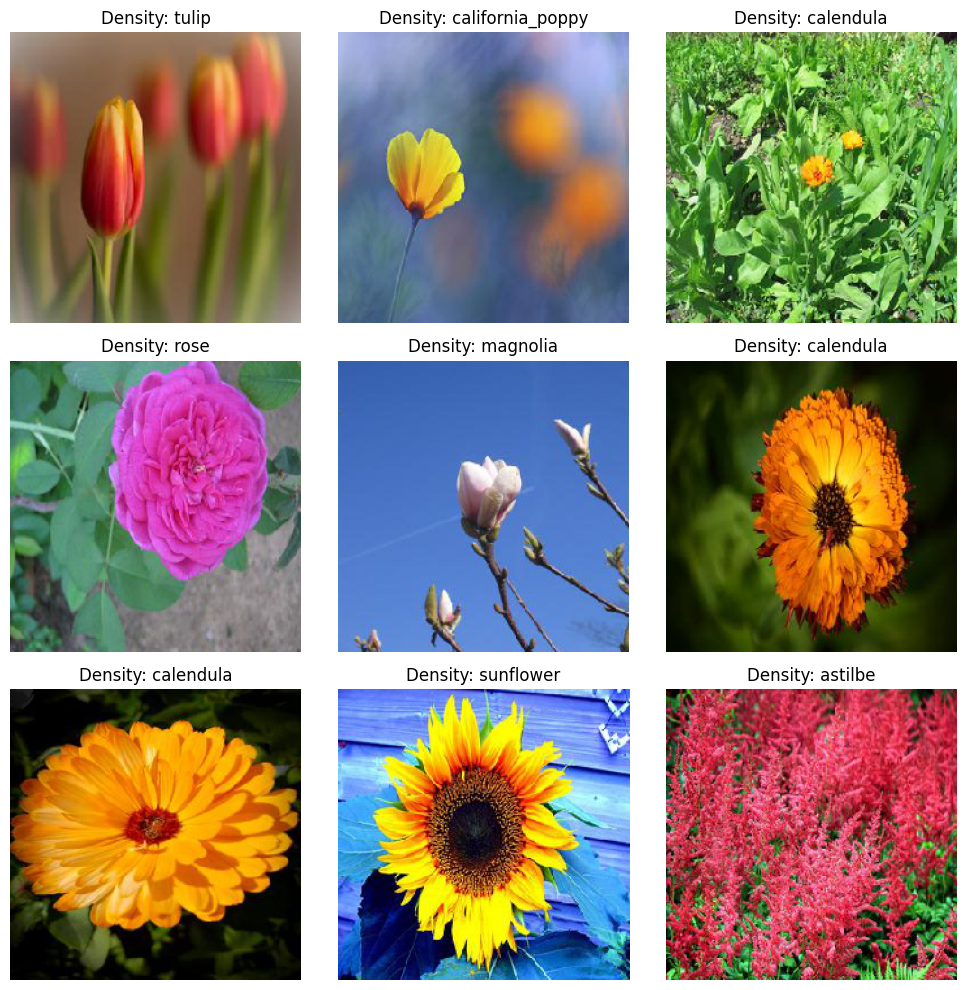

In [22]:
batch_size = 9

images, labels = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(min(len(images), 9)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    label = np.argmax(labels[i])
    plt.title(f"Density: {classes[label]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [29]:
model=keras.models.Sequential()

model.add(Conv2D(64,(3,3),input_shape=(224,224,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.1))


model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(16,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 222, 222, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    95,552,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │         8,208 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,601,232 (364.69 MB)

 Trainable params: 95,600,080 (364.69 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [31]:
weight_path = "cnn_weights.best.weights.h5"

checkpoint = ModelCheckpoint(weight_path, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)

early = EarlyStopping(monitor="val_accuracy", 
                      mode="max", 
                      patience=4)

callbacks_list = [checkpoint, early]

In [32]:
epoch_num=20
history=model.fit(train_generator,epochs=epoch_num,validation_data=(valid_generator),callbacks=callbacks_list)

Epoch 1/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.3009 - loss: 2.4328
Epoch 1: val_accuracy improved from -inf to 0.15893, saving model to cnn_weights.best.weights.h5
245/245 ━━━━━━━━━━━━━━━━━━━━ 207s 842ms/step - accuracy: 0.3012 - loss: 2.4313 - val_accuracy: 0.1589 - val_loss: 2.5883
Epoch 2/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 804ms/step - accuracy: 0.4663 - loss: 1.6293
Epoch 2: val_accuracy improved from 0.15893 to 0.32619, saving model to cnn_weights.best.weights.h5
245/245 ━━━━━━━━━━━━━━━━━━━━ 205s 836ms/step - accuracy: 0.4664 - loss: 1.6291 - val_accuracy: 0.3262 - val_loss: 1.9055
Epoch 3/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.6277 - loss: 1.1478
Epoch 3: val_accuracy improved from 0.32619 to 0.63988, saving model to cnn_weights.best.weights.h5
245/245 ━━━━━━━━━━━━━━━━━━━━ 206s 841ms/step - accuracy: 0.6277 - loss: 1.1477 - val_accuracy: 0.6399 - val_loss: 1.1877
Epoch 4/20
245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.7813 - l

In [33]:
model.load_weights(weight_path)

In [34]:
evaluation_result = model.evaluate(test_generator)

print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - accuracy: 0.7325 - loss: 1.1424
Test Loss: 1.1640576124191284
Test Accuracy: 0.7303571701049805


In [35]:
y_pred = model.predict(test_generator)

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 216ms/step


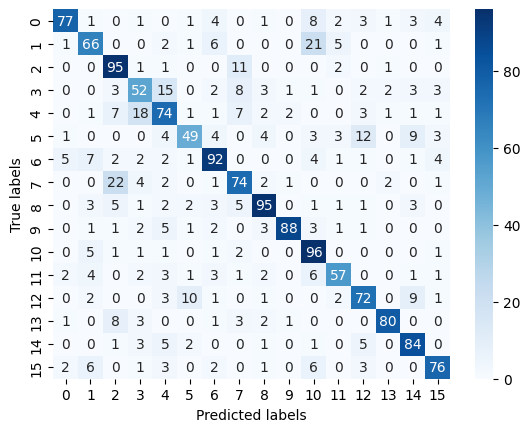

In [36]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = test_generator.classes


confusion_Matrix = confusion_matrix(y_test_classes, y_pred_classes)

sns.heatmap(confusion_Matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

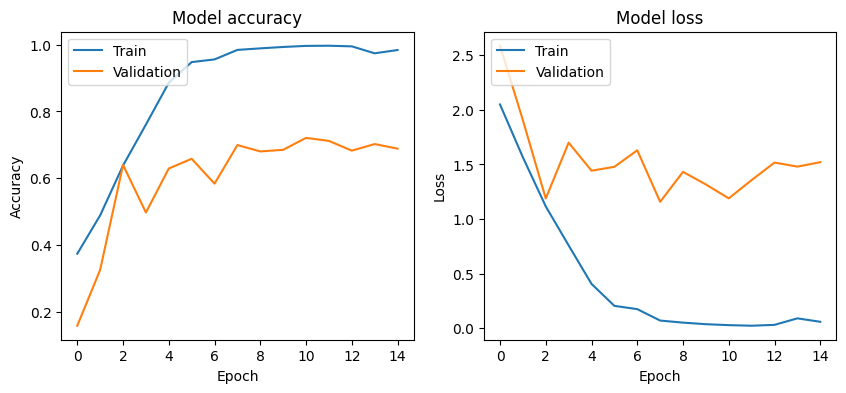

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [38]:
print(classification_report(y_test_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.87      0.73      0.79       106
           1       0.69      0.64      0.66       103
           2       0.66      0.86      0.74       111
           3       0.57      0.55      0.56        95
           4       0.61      0.62      0.61       119
           5       0.71      0.53      0.61        92
           6       0.75      0.75      0.75       122
           7       0.67      0.68      0.67       109
           8       0.81      0.78      0.79       122
           9       0.95      0.81      0.88       108
          10       0.64      0.89      0.74       108
          11       0.77      0.69      0.73        83
          12       0.70      0.71      0.71       101
          13       0.92      0.81      0.86        99
          14       0.74      0.82      0.78       102
          15       0.79      0.76      0.78       100

    accuracy                           0.73      1680
   macro avg       0.74   

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


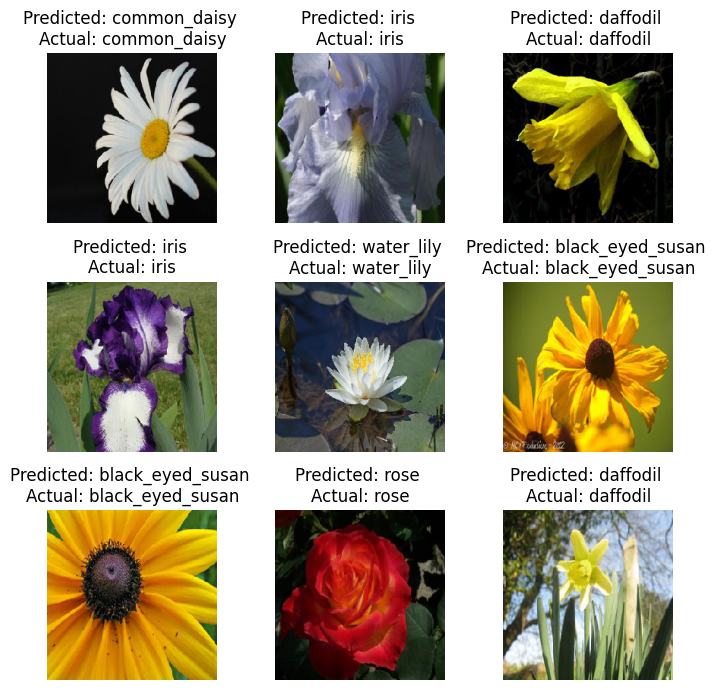

In [39]:
x_test,y_test=next(test_generator)
fig, axs = plt.subplots(3, 3, figsize=(7, 7))
axs = axs.flatten()

for i in range(9):
    predicted = model.predict(np.array([x_test[i]]))
    predictedClass = np.argmax(predicted)
    actual = np.argmax(y_test[i])
    axs[i].imshow(x_test[i], cmap='gray')
    axs[i].set_title(f'Predicted: {classes[predictedClass]} \nActual: {classes[actual]}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()